# Final List of oncRNAs
Here we also visualized loci to break up and narrow down the loci we see.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json as js
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
oncRNAs = pd.read_csv("results/thresholded_oncRNAs.bed", header=None, sep="\t")
oncRNAs["length"] = oncRNAs[2] - oncRNAs[1]
oncRNAs

,0,1,2,3,4,5,length
0,chr6,27815103,27815138,chr6:27815103-27815138:+,.,+,35
1,chr7,13735449,13735471,chr7:13735449-13735471:-,.,-,22
2,chr7,29921213,29921331,chr7:29921213-29921331:-,.,-,118
3,chr9,126496950,126496971,chr9:126496950-126496971:-,.,-,21
4,chr11,112396454,112396473,chr11:112396454-112396473:+,.,+,19
...,...,...,...,...,...,...,...
108,chr1,84497400,84497524,chr1:84497400-84497524:+,.,+,124
109,chr9,14613887,14613949,chr9:14613887-14613949:-,.,-,62
110,chr12,11171716,11171829,chr12:11171716-11171829:+,.,+,113
111,chr2,111153783,111153820,chr2:111153783-111153820:+,.,+,37


(array([45., 20.,  8., 17., 11.,  6.,  3.,  0.,  1.,  2.]),
 array([ 18. ,  35.6,  53.2,  70.8,  88.4, 106. , 123.6, 141.2, 158.8,
        176.4, 194. ]),
 <BarContainer object of 10 artists>)

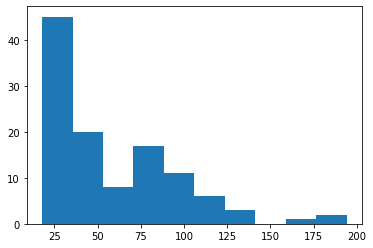

In [3]:
plt.hist(oncRNAs["length"])

# Visualization

In [12]:
with open('data/counts/cell_lines_cpm_map.json', 'r') as f:
    cell_lines_cpm_map = js.load(f)
    f.close()
with open('data/counts/cell_lines_loci_counts.json', 'r') as f:
    sample_loci = js.load(f)
    f.close()
del sample_loci["LM2_2_cell_S37"]

In [13]:
#Create df for heatmap visualization
loci_exp = {}
for locus in oncRNAs[3]:
    loci_exp[locus] = {}
    for cell_line, loci_dict in sample_loci.items():
        if locus in loci_dict:
            loci_exp[locus][cell_line] = loci_dict[locus] * cell_lines_cpm_map[cell_line] #Transform raw count to cpm. Note we use the cpm_map from non ex-filtered dataset to capture whole count.
        else:
            loci_exp[locus][cell_line] = 0

In [14]:
loci_exp_df = pd.DataFrame.from_dict(loci_exp, orient="index")

In [15]:
subtype_map = {"MDA453":"HER2+", "SKBR-3":"HER2+", 
              "HUMEC":"Normal", "ZR75-1":"Luminal", "HCC38": "TNBC",
              "CN34":"TNBC", "MCF7": "Luminal", "MDA231":"TNBC", 
              "LM2":"Met", "LM1a":"Met"}

In [16]:
colData = pd.DataFrame(loci_exp_df.columns, columns=["Sample"]) #Sample column contains all the samples
colData["Cell Line"] = colData["Sample"].apply(lambda x: x.split("_")[0]) #From sample name, get cell line information
colData["Subtype"] = colData["Cell Line"].apply(lambda x: subtype_map[x]) #Base on cell line, map to subtype category
colData = colData.sort_values("Cell Line").sort_values("Subtype") #First sort by cell line then by subtype
colData = pd.concat([colData[colData["Subtype"] == "Normal"], colData[colData["Subtype"] != "Normal"]]).copy()
colData = colData.set_index("Subtype", drop=False)

colors = sns.color_palette("Paired", len(colData["Subtype"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Subtype"].unique()), colors))
col_colors = colData["Subtype"].map(lut)

In [17]:
#Max norm
loci_df = np.zeros(loci_exp_df.shape)
for i in range(loci_exp_df.shape[0]):
    max_per_row = np.max(loci_exp_df.iloc[i])
    loci_df[i] = np.divide(loci_exp_df.iloc[i], max_per_row) #Max-norm

In [18]:
loci_df = pd.DataFrame(loci_df, index=loci_exp_df.index, columns=loci_exp_df.columns)
loci_df = loci_df[list(colData["Sample"])] #Set columns to match colData order
loci_df.columns = colData["Subtype"]

<Figure size 1440x1440 with 0 Axes>

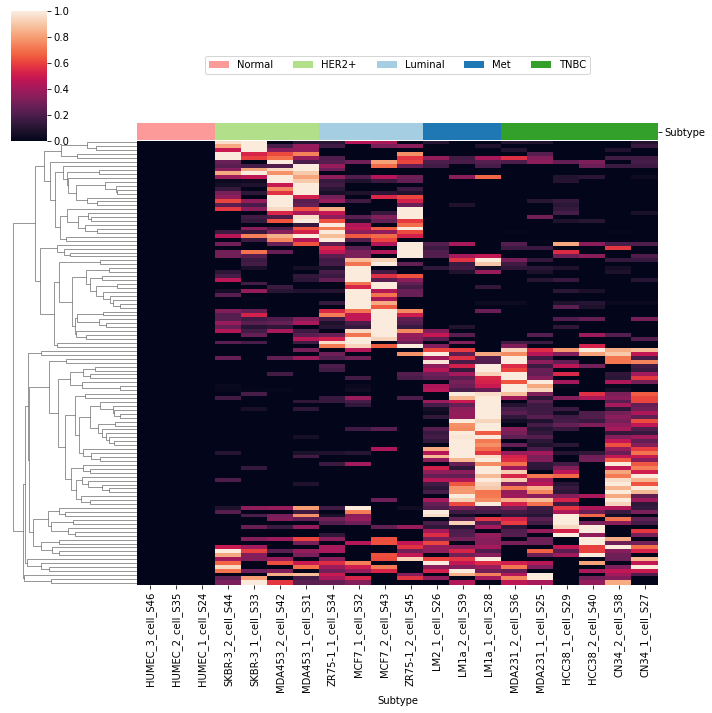

In [19]:
plt.figure(figsize=(20,20))
g=sns.clustermap(loci_df, col_cluster=False, col_colors=col_colors,yticklabels=False, xticklabels=colData["Sample"], method="average", rasterized=True)
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/cell_lines_oncRNA_loci_heatmap.pdf")

In [23]:
oncRNAs.shape

(113, 7)

# Visualize

In [20]:
pos_density = pd.read_csv("data/IC/all_samples_pos_bg.txt", header=None, sep="\t")
neg_density = pd.read_csv("data/IC/all_samples_neg_bg.txt", header=None, sep="\t")

chr1:226365958-226366045:-
226365958
226366045


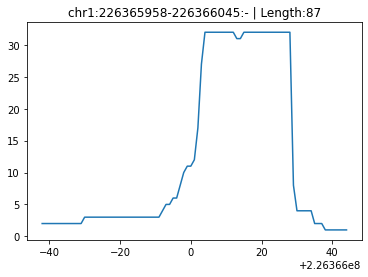

In [534]:
oncRNA = oncRNAs.iloc[112]
density = neg_density if oncRNA[5] == "-" else pos_density
density = density[density[0] == oncRNA[0]] #Match reference
density = density[(density[1] >= oncRNA[1]) & (density[2] <= oncRNA[2])] #Match oncRNA loci
coord = []
coverage = []
first = density.iloc[0][1] #Start of loci
for i in range(density.shape[0]):
    row = density.iloc[i]
    start = row[1]
    end = row[2]
    count = row[3]
    assert first == start #Ensure continuity
    while start < end:
        coord.append(start)
        coverage.append(count)
        start += 1
        first += 1
    
density_df = pd.DataFrame({"Coord":coord, "Coverage":coverage})
plt.plot(density_df["Coord"], density_df["Coverage"])
plt.title(oncRNA[3] + f" | Length:{oncRNA[2] - oncRNA[1]}")
print(oncRNA[3])
print(oncRNA[1])
print(oncRNA[2])

In [529]:
density = neg_density if oncRNA[5] == "-" else pos_density
density = density[density[0] == oncRNA[0]] #Match reference

In [530]:
density[density[1] >= oncRNA[1]].sort_values(1).head(12)

,0,1,2,3
158092,chr1,226365958,226365970,2
158093,chr1,226365970,226365992,3
158094,chr1,226365992,226365993,4
158095,chr1,226365993,226365995,5
158096,chr1,226365995,226365997,6
158097,chr1,226365997,226365998,8
158098,chr1,226365998,226365999,10
158099,chr1,226365999,226366001,11
158100,chr1,226366001,226366002,12
158101,chr1,226366002,226366003,17


In [535]:
split_loci = {"chr7:29921213-29921331:-":["chr7:29921222-29921260:-"],
             "chr12:71664021-71664096:+":["chr12:71664059-71664094:+"],
             "chrX:127317160-127317210:+":["chrX:127317161-127317185:+", "chrX:127317185-127317210:+"],
             "chr3:172821369-172821477:+":["chr3:172821433-172821476:+"],
             "chr6:50844053-50844173:+":["chr6:50844095-50844138:+"],
             "chr6:52264623-52264696:-":["chr6:52264623-52264650:-"],
             "chr8:143867927-143868000:-":["chr8:143867944-143867977:-"],
             "chr9:113514723-113514767:+":["chr9:113514723-113514758:+"],
             "chr10:32010001-32010080:-":["chr10:32010017-32010041:-", "chr10:32010039-32010064:-"],
             "chr10:32017171-32017214:-":["chr10:32017175-32017211:-"],
             "chr12:46229560-46229641:-":["chr12:46229560-46229586:-"],
             "chr15:41402530-41402603:+":["chr15:41402563-41402593:+"],
             "chr1:156701076-156701120:-":["chr1:156701093-156701120:-"],
             "chr17:64545314-64545505:-":["chr17:64545378-64545408:-"],
             "chr19:17337553-17337641:+":["chr19:17337577-17337598:+", "chr19:17337577-17337619:+"],
             "chr19:39473382-39473416:+":["chr19:39473388-39473416:+"],
             "chr1:156070110-156070162:+":["chr1:156070135-156070162:+"],
             "chr2:121727242-121727324:-":["chr2:121727249-121727276:-"],
             "chr2:237545697-237545743:+":["chr2:237545723-237545743:+"],
             "chr8:143866581-143866679:-":["chr8:143866646-143866678:-"],
             "chr9:126882239-126882433:+":["chr9:126882358-126882393:+"],
             "chr15:40874157-40874234:-":["chr15:40874171-40874194:-", "chr15:40874194-40874223:-"],
             "chr16:15576880-15576933:-":["chr16:15576883-15576903:-", "chr16:15576902-15576930:-"],
             "chr1:200407020-200407123:-":["chr1:200407043-200407080:-"],
             "chr16:21526902-21526948:-":["chr16:21526905-21526945:-"],
             "chr16:28845601-28845647:+":["chr16:28845605-28845636:+"],
             "chr20:50752735-50752776:+":["chr20:50752738-50752775:+"],
             "chrX:16712734-16712802:+":["chrX:16712734-16712758:+"],
             "chr1:179103603-179103641:-":["chr1:179103605-179103642:-"],
             "chr6:57105554-57105620:+":["chr6:57105566-57105593:+"],
             "chr21:38415081-38415215:+":["chr21:38415082-38415107:+", "chr21:38415112-38415137:+", "chr21:38415150-38415176:+"],
             "chr3:179399575-179399631:-":["chr3:179399591-179399630:-"],
             "chr7:66811360-66811433:+":["chr7:66811364-66811396:+"],
             "chr4:1980712-1980744:+":["chr4:1980720-1980744:+"],
             "chr7:30082319-30082414:+":["chr7:30082357-30082400:+"],
             "chr7:36389850-36389931:+":["chr7:36389874-36389905:+"],
             "chr7:92605706-92605776:-":["chr7:92605747-92605776:-"],
             "chr10:59791859-59791902:-":["chr10:59791867-59791902:-"],
             "chr17:68101412-68101494:-":["chr17:68101451-68101480:-"],
             "chr2:236124627-236124800:+":["chr2:236124710-236124730:+", "chr2:236124728-236124756:+", "chr2:236124757-236124796:+"],
             "chr17:39716415-39716514:+":["chr17:39716433-39716477:+", "chr17:39716477-39716511:+"],
             "chr4:55336774-55336832:-":["chr4:55336788-55336832:-"],
             "chr12:45817728-45817833:+":["chr12:45817737-45817772:+"],
             "chr16:85015943-85016011:-":["chr16:85015947-85015986:-", "chr16:85015986-85016011:-"], 
             "chr20:36916711-36916760:-":["chr20:36916723-36916760:-"],
             "chr2:102716142-102716211:-":["chr2:102716150-102716188:-"],
             "chr5:154057151-154057189:+":["chr5:154057160-154057187:+"],
             "chr8:119982676-119982771:-":["chr8:119982702-119982733:-", "chr8:119982746-119982769:-"],
             "chr17:79833155-79833259:-":["chr17:79833156-79833184:-"],
             "chr20:62327667-62327746:-":["chr20:62327667-62327693:-"],
             "chr1:43164358-43164482:-":["chr1:43164390-43164413:-", "chr1:43164424-43164450:-", "chr1:43164450-43164476:-" ],
             "chr7:139299611-139299712:+":["chr7:139299611-139299712:+"],
             "chr6:149661721-149661811:-":["chr6:149661726-149661760:-"],
              "chr7:139299611-139299712:+":["chr7:139299644-139299673:+"],
              "chr8:103430637-103430690:+":["chr8:103430644-103430672:+", "chr8:103430668-103430688:+"],
              "chr11:63625994-63626105:-":["chr11:63626066-63626096:-"],
              "chr20:50583874-50583980:+":["chr20:50583896-50583925:+", "chr20:50583925-50583953:+"],
              "chr3:42224520-42224615:+":["chr3:42224521-42224556:+"],
              "chr1:149558545-149558588:-":["chr1:149558545-149558569:-"],
              "chr20:56639188-56639276:+":["chr20:56639196-56639220:+", "chr20:56639222-56639260:+"],
              "chr8:123042578-123042655:+":["chr8:123042585-123042611:+"],
              "chr17:67340363-67340436:-":["chr17:67340381-67340414:-"],
              "chr20:9357008-9357103:+":["chr20:9357015-9357034:+", "chr20:9357032-9357052:+", "chr20:9357050-9357077:+",  "chr20:9357075-9357096:+"],
              "chr19:10684987-10685034:+":["chr19:10684999-10685031:+"],
              "chr1:84497400-84497524:+":["chr1:84497435-84497468:+", "chr1:84497468-84497495:+"],
              "chr9:14613887-14613949:-":["chr9:14613909-14613941:-"],
              "chr12:11171716-11171829:+":["chr12:11171716-11171741:+", "chr12:11171772-11171799:+"],
              "chr2:111153783-111153820:+":["chr2:111153784-111153814:+"],
              "chr1:226365958-226366045:-":["chr1:226365997-226366030:-"]}
len(split_loci)

68

Refined 68 of the loci.

In [536]:
final_list = []
for rna in oncRNAs[3]:
    if rna in split_loci:
        final_list.extend(split_loci[rna])
    else:
        final_list.append(rna)
len(final_list)

135

In [537]:
with open("results/oncRNA_list.bed", "w") as out:
    for locus in final_list:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")          

# Test to Make Sure No Errors

With `-v` we test to make sure all of the rnas in the `final_oncRNA_list.bed` file maps to one of the oncRNA annotations. If no errors nothing should be reported.

In [538]:
%%bash
bedtools intersect -v -s -a results/oncRNA_list.bed -b results/thresholded_oncRNAs.bed

Great.

Here we do the opposite. To make sure all the oncRNAs in the `thresholded_oncRNAs.bed` file are accounted for.

In [539]:
%%bash
bedtools intersect -v -s -a results/thresholded_oncRNAs.bed -b results/oncRNA_list.bed

Great.

In [540]:
%%bash
bedtools intersect -wao -s -a results/thresholded_oncRNAs.bed -b results/oncRNA_list.bed > results/map_oncRNAs.bed

# Final Check of Lengths

In [541]:
lengths = []
for rna in final_list:
    start = int(rna.split(":")[1].split("-")[0])
    end = int(rna.split(":")[1].split("-")[1])
    lengths.append(end-start)

(array([ 9., 15., 16., 30., 13., 20., 15.,  7.,  4.,  6.]),
 array([18. , 20.6, 23.2, 25.8, 28.4, 31. , 33.6, 36.2, 38.8, 41.4, 44. ]),
 <BarContainer object of 10 artists>)

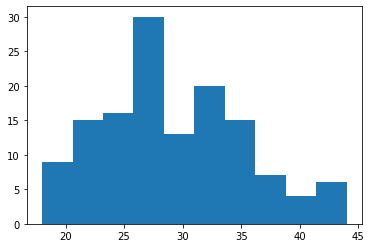

In [542]:
plt.hist(lengths)

# Final Check of Loci

In [758]:
final_check = pd.read_csv("results/map_oncRNAs.bed", sep="\t", header=None)
print(final_check.shape)
final_check.head()

(135, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr6,27815103,27815138,chr6:27815103-27815138:+,.,+,chr6,27815103,27815138,chr6:27815103-27815138:+,.,+,35
1,chr7,13735449,13735471,chr7:13735449-13735471:-,.,-,chr7,13735449,13735471,chr7:13735449-13735471:-,.,-,22
2,chr7,29921213,29921331,chr7:29921213-29921331:-,.,-,chr7,29921222,29921260,chr7:29921222-29921260:-,.,-,38
3,chr9,126496950,126496971,chr9:126496950-126496971:-,.,-,chr9,126496950,126496971,chr9:126496950-126496971:-,.,-,21
4,chr11,112396454,112396473,chr11:112396454-112396473:+,.,+,chr11,112396454,112396473,chr11:112396454-112396473:+,.,+,19


In [849]:
j = 97

97
chr1:43164390-43164413:-
chr1:43164358-43164482:-


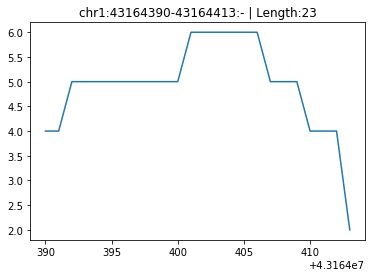

In [850]:
oncRNA = final_check.iloc[j]
loci_start = oncRNA[7]
loci_end = oncRNA[8]
density = neg_density if oncRNA[5] == "-" else pos_density
density = density[density[0] == oncRNA[0]]
density = density[(density[1] >= oncRNA[1]) & (density[2] <= oncRNA[2])]
coord = []
coverage = []
first = density.iloc[0][1]
for i in range(density.shape[0]):
    row = density.iloc[i]
    start = row[1]
    end = row[2]
    count = row[3]
    while first < start: #ensure continuity
        coord.append(first)
        coverage.append(0)
        first += 1
    while start < end:
        coord.append(start)
        coverage.append(count)
        start += 1
        first += 1
        
density_df = pd.DataFrame({"Coord":coord[loci_start-oncRNA[1]:loci_end - oncRNA[1]+1], "Coverage":coverage[loci_start-oncRNA[1]:loci_end - oncRNA[1]+1]})
plt.plot(density_df["Coord"], density_df["Coverage"])
new_locus = f"{oncRNA[0]}:{loci_start}-{loci_end}:{oncRNA[5]}"
plt.title(new_locus + f" | Length:{loci_end - loci_start}")
print(j)
print(new_locus)
print(oncRNA[3])
j += 1

In [829]:
density = neg_density if oncRNA[5] == "-" else pos_density
density = density[density[0] == oncRNA[0]] #Match reference
density[density[1] >= oncRNA[1] - 30].sort_values(1).head(5)

,0,1,2,3
551516,chr6,27815078,27815079,5
551517,chr6,27815079,27815081,2
551518,chr6,27815081,27815084,1
551519,chr6,27815084,27815086,3
551520,chr6,27815086,27815092,4


**To Remove (coverage too low <= 5):** <br>
chr16:85015986-85016011:- <br>
chr8:119982702-119982733:- <br>
chr8:119982746-119982769:- <br>


In [851]:
to_remove = set(["chr16:85015986-85016011:-", "chr8:119982702-119982733:-", 
                 "chr8:119982746-119982769:-"])

In [852]:
with open("results/final_oncRNA_list.bed", "w") as out:
    for locus in final_check[9]:
        if locus in to_remove:
            continue
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")          

In [853]:
len(pd.read_csv("results/final_oncRNA_list.bed", header=None, sep="\t")[3].unique())

132

At this step we removed one whole loci and one splitted locus due to low coverage by genome coverage of the samples.

## Convert to fastq sequences file

In [858]:
%%bash
echo "bedtools getfasta -fo results/final_oncRNA.fa -fi /rumi/shams/genomes/hg38/hg38.fa -bed results/final_oncRNA_list.bed -s";
bedtools getfasta -fo results/final_oncRNA.fa -fi /rumi/shams/genomes/hg38/hg38.fa -bed results/final_oncRNA_list.bed -s;

bedtools getfasta -fo results/final_oncRNA.fa -fi /rumi/shams/genomes/hg38/hg38.fa -bed results/final_oncRNA_list.bed -s


In [859]:
with open('results/final_oncRNA.txt', "w") as out:
    with open("results/final_oncRNA.fa", "r") as read:
        for line in read:
            if ">" not in line:
                out.write(line)

# Annotations
Make sure none of these finalized oncRNAs map to a known smRNAs. Below code should return 0 results.

In [860]:
%%bash
bedtools intersect -wo -s -a results/final_oncRNA_list.bed -b /rumi/shams/jwang/genomes/hg38/dashr.v2.smRNA.hg38.bed

# Done